<a href="https://colab.research.google.com/github/Kasperbang/AEEEM/blob/main/prosjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTEBOOKS**:

AUX NOTEBOOK LINK:

https://colab.research.google.com/drive/1hzOTMxUuArJ9aEHd3ZeUUw8YHY1pUEP7?usp=sharing

AEEEM:

https://colab.research.google.com/drive/1EUIvKVZ1T00ysia1UZwoiDXjDCfJ07K-?usp=sharing

NASA:

https://colab.research.google.com/drive/1Twj7l6iBBVZYqjupfwworA0vvFyXt1_J?usp=sharing


PROMISE:

https://colab.research.google.com/drive/1TE3GoPllsuSpkg4Sdu6vP3JEtDMqVyWN?usp=sharing


In [1]:
#Run AUX Notebook:


MessageError: ignored

# To do

* Random forrest! We need to finetune the parameters and potentially punish false negatives more.
* Spectral clustering algorithm (almost there I think)

* Logistic regression: We are not getting good results for everything except AEEEM within, but this one is still 0.1 off what they are getting. All other results are very bad.

* 

* Feature selection. AEEEM is most important.
  
* Theory / descrition of Spectral clustering

*   Implement the Scott Knott- test
*   Discussion
*   Reasearch Q



# Title


# Introduction

The objective of this project is to reproduce the study by Zhang, Zheng, Zou, and Hassan in 2016: "Cross-project Defect Prediction Using a Connectivity-based Unsupervised Classifier". The paper aims to predict software defects using known data from 18 different projects extracted from three different datasets. The authors first apply known machine-learning algorithms such as k-means, naive bayes, logistic regression, and random forest to test if any of these can delivery satisfactory performances. However, they all seem to have their respective problems. 

In software defect prediction, there is typically only a very limited amount of training data. This is a natural consequence to the heterogeneity that exists among software. As a result, superviced classifiers are not being fed an adequate amount of training data. K-means is a known and widely used algorithm for unsupervised learning, but it performs poorly in this setting. One of the main reasons, according to Zhang et al, is that the data is not linearly seperable (other reasons are explained in the section on k-means clustering). 

The underperformance or general impracticability of these algorithms thus leaves a vacuum. Spectral Clustering rises to fill this vacuum and are superior due to e.g. less rigid assumptions on linear seperability and the fact that it is unsupervised and thus do not need training data from homogene projects.


The authors do largely not themselves perform any feature selection which is one of the optimizations we will do. More specifically, we will try to impose a higher cost to our algorithms for false negatives than for false positives. In the time of a global pandemic, we are reminded that misclassifiying a positive, as a negative, can be much worse than misclassifying a negative as a positive. As a result, we want to impose a higher cost to our models for making false-negatives. 



# Research Questions

## Q1: How does spactral clustering performs compared to the supervised learning methods. 



# Auxiliary functions and set up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.io.arff import loadarff 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [ ]:
def investigate_df(df):
    data_points = len(df["class"])
    buggy = df["class"].sum()
    percent_buggy = round((buggy / data_points )* 100, 1) 
    print('Number of data points = ',data_points)
    print('Number of buggy data points = ',buggy)
    print('Percent buggy data points = ', percent_buggy)
    return 

    
def find_correlated_columns(df, treshold):
    correlated_columns = []
    cor = df.corr()
    np.fill_diagonal(cor.values, 0)
    column_names = (cor.columns).to_list()
    i = 0
    current_length = len(column_names) - 1
    while i < current_length:
        max_value = max(abs(cor.iloc[i,:]))
        if max_value > treshold:
            correlated_columns.append(column_names[i])
            cor.drop(columns=column_names[i], inplace=True)
            current_length = current_length - 1

        i = i + 1 
    return correlated_columns


def drop_variables(df, drop_list):
    df.drop(columns=drop_list, inplace=True)
    return

def scale_data_unsupervised(df):
    std_scaler = StandardScaler()
    df_std = pd.DataFrame(std_scaler.fit_transform(df), columns=df.columns)
    
    return df_std

def scale_data(train_data, test_data):
    X_train = train_data.iloc[:,:-1]
    X_test = test_data.iloc[:,:-1]
    
    std_scaler = StandardScaler()
    
    scaled_train_X = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
    scaled_test_X = pd.DataFrame(std_scaler.fit_transform(X_test), columns=X_test.columns)

    return scaled_train_X, scaled_test_X


def numerical_response(df, data_set):
    if data_set == 'AEEEM':
        
        for i in range(len(df["class"])):
            if df["class"][i][2:7] == 'clean':
                df["class"][i] = 0
            else: 
                df["class"][i] = 1

        # df.loc[df["class"] == b'buggy', "class"] = 1
        # df.loc[df["class"] == b'clean', "class"] = 0

        
        
    if data_set == 'NASA':
        df.rename(columns={'Defective':'class'}, inplace=True)
        df.loc[df["class"] == 'Y', "class"] = 1
        df.loc[df["class"] == 'N', "class"] = 0
        
        
    if data_set == 'PROMISE':
        df.rename(columns={'bug':'class'}, inplace=True)
        df.loc[df["class"] > 0, "class"] = 1
          
    return 



def AUC_unsupervised(function, df, project_list = 0):
    y_pred, y_test = function(df)
    auc = roc_auc_score(y_test, y_pred)
    
    return np.round(np.mean(auc), 2)
    
    
def average_AUC_cross(function, df_test, projects = 0):
    n = len(projects)
    auc = np.zeros(n)
    for j in range(n):
        df_train = projects[j]
        y_pred, y_test = function(df_train, df_test)
        auc[j] = roc_auc_score(y_test, y_pred)
        
    return  np.round(np.mean(auc), 2)


def average_AUC_within(function, df, project_list = 0):
    t = 500 # change to 500 for final results
    auc = np.zeros(2*t)
    for i in range(t):
        df1, df2 = train_test_split(df, test_size=0.5)
        y_pred, y_test = function(df1, df2)
        auc[i] = roc_auc_score(y_test, y_pred)
        y_pred, y_test = function(df2, df1)
        auc[2*t - i - 1] = roc_auc_score(y_test, y_pred)
        
    return np.round(np.mean(auc), 2)



def get_auc_scores(project_dict, func, auc_func):
    average_auc_list = []
    
    
    project_list = list(project_dict.values())
    project_names = list(project_dict.keys())
    
    all_projects = project_list

    for p in range(len(project_list)): 
        # only for cross project        
        train_project = all_projects.copy()
        train_project.pop(p)
        
        # for all (cross project, within project and unsupervised)
        test_project = project_list[p]

        auc = auc_func(func, test_project, train_project)
        print('\nAUC score for ' + project_names[p] + ' :', auc)
        average_auc_list.append(auc)
    
    print('\nMean AUC score for all projects:', np.round(np.mean(average_auc_list),2))  
    return 


def to_csv_supervised(project_dict, function_dict, file_name):
    measure = ['CP', 'WP', 'diff']
    m = len(measure)
    function_names = list(function_dict.keys())
    column_names =[]
    for i in range(len(function_dict)):
        for j in range(m):
            column_names.append(function_names[i] + '\n' + measure[j])
    project_list = list(project_dict.values())
    function_list = list(function_dict.values())
    row_names = list(project_dict.keys())
    
    col = 0
    all_projects = project_list
    
    # initialize data
    data = np.zeros((len(project_list), len(function_list)*m))
    for func in function_list:
        print(func) # del
        for p in range(len(project_list)):         
            train_project = all_projects.copy()
            train_project.pop(p)
            
            test_project = project_list[p]
            
            AUC_cross = average_AUC_cross(func, test_project, train_project)
            AUC_within = average_AUC_within(func, test_project)
            
            data[p,col] = AUC_cross
            data[p,col+1] = AUC_within
            data[p,col+2] = round(AUC_within - AUC_cross,2)
            print(project_list[p])
            
        col = col + m
    df = pd.DataFrame(data, index = row_names) 
    df.to_csv(file_name, encoding='utf-8', index=True, header=column_names)
    
    return


def to_csv_unsupervised(project_dict, function_dict, file_name):
    function_names = list(function_dict.keys())
    column_names =[]
    for i in range(len(function_dict)):
        column_names.append(function_names[i])
    
    project_list = list(project_dict.values())
    function_list = list(function_dict.values())
    row_names = list(project_dict.keys())
    
    col = 0
    all_projects = project_list
    
    # initialize data
    data = np.zeros((len(project_list), len(function_list)))
    for func in function_list:
        for p in range(len(project_list)):         
            df = project_list[p]
    
            AUC = AUC_unsupervised(func, df)
            data[p,col] = AUC
            
    df = pd.DataFrame(data, index = row_names) 
    df.to_csv(file_name, encoding='utf-8', index=True, header=column_names)
    
    return

#Using Pearson Correlation
def pearsoncor(df):
  df.corr()
  sns.heatmap(df.corr())
  return

def histofdf(df):  
  df.hist(bins=20, 
          figsize=(25, 55),
          xlabelsize = 12, 
          grid = False, 
          linewidth=3.0,
          layout = (16,4))
  return

def plot_two_columns(df, col_name1, col_name2):
    plt.subplot(1, 2, 2)
    plt.hist2d(df[col_name1], df[col_name2], cmap=plt.cm.YlGn)
    plt.colorbar()
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    
    plt.subplot(1, 2,1)
    plt.scatter(df[col_name1], df[col_name2])
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()
    return

# Explanation (and exploration) of the data sets

### AEEEM


#See APPENDIX 1 for explanation of all variables. Only the most important will be discussed in the project directly.


#### Show them examples from the data
correlation between our two favourite metrics?

In [ ]:
import requests
import io


url = "https://raw.githubusercontent.com/Kasperbang/AEEEM/main/AEEEM_EQ.csv" 
download = requests.get(url).content
AEEEM_EQ = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/Kasperbang/AEEEM/main/AEEEM_JDT.csv" 
download = requests.get(url).content
AEEEM_JDT = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/Kasperbang/AEEEM/main/AEEEM_LC.csv" 
download = requests.get(url).content
AEEEM_LC = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/Kasperbang/AEEEM/main/AEEEM_ML.csv" 
download = requests.get(url).content
AEEEM_ML = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/Kasperbang/AEEEM/main/AEEEM_PDE.csv" 
download = requests.get(url).content
AEEEM_PDE = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [ ]:
numerical_response(AEEEM_JDT, 'AEEEM')
numerical_response(AEEEM_EQ, 'AEEEM')
numerical_response(AEEEM_LC, 'AEEEM')
numerical_response(AEEEM_ML, 'AEEEM')
numerical_response(AEEEM_PDE, 'AEEEM') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Feature Selection - AEEEM DATASET
As seen above, this dataset has 61 predictor variables which prove impractical for multiple reasons. 

1)
Firstly, it is overwhelming to actually understand what the variables are telling us and human intuition is therefore benched. We do not want that as it eliminates our chance to sanity check. Decreasing dimensionality would therefore increase interpretability. 

2)
Secondly, and more theoretically founded, the enormous amount of predictors can lead to the curse of dimensionality. The curse of dimensionality, in its essence, is about the fact that as dimensions increase, clusters become more dissimilar. 

An intuitive example could be to investigate 100 people and only ask them about their weight to predict their sex. This would create two distinct clusters: Men and Women. However, imagine doing the same in multi-dimensional space. Asking about hair color, eye color, length of toes, height, weight, number of scars, etc. This would clearly increase the dissimilarity within the clusters and therefore make it less certain how to predict a marginal person's gender.

3)
Thirdly, having many dimensions to optimize over increases computation time. 

4)
Lastly, it follows from the imbalanced nature of our data-set that machine learning models works poorly with default parameters. The logic may be understood more clearly with another intuitive example. Imaginge that only 1% of observations are defect, that would mean that the algorithm can obtain a 99% accuracy by simply classifying everything as not-defect. 
As a result, it is important to decide if the model should be trained to improve Sensitivity ("Number of predicted defects"/"Total number of defects"), Specificity ("Number of predicted negatives" / "Total negatives"), or the AUC score which is the relationship between the two.


As a result, we will now proceed to decrease the number of features. We will discover how we do so for this dataset. 

***SIMILAR THOUGHTS GOES INTO THE SAME DIMENSIONALITY REDUCTION FOR THE OTHER DATASETS***



Now we will proceed by selection our features. We follow these rules:

1) Intuition. Features that are not explained in Appendix 1 will be discarded. 

2) Apply variance threshold method. The notion is that 0-variance variables have no predictive power. Since our dataset is imbalanced  (see Table 1), we will be less strict than suggested on the official sklearn documentation to "VarianceThreshold". We apply this method because we, through manual examination, realized that multiple features provide very little variance and thus only adds complexity and noise. 

3) Recursive feature selection which recusively goes through our model and removes the least important features. Forward feature selection. Best model selection. 

4) We can apply over/under-sampling.
  Over sampling is the exercise of increasing the number of the minority class to increase the balance of the data set. That is, to add randomly selected rows with defects. Under-sampling is the exact opposite. To remove a number of randomly selected rows with not-defects to increase sampling.

  

In [ ]:
'''
1) Intuition. Here we are removing features that are either not explained or 
have any intuitive implication to our outcome variable.
This will help us improve interpretability.
'''

drop_list = ["Unnamed: 0"]
correlated = find_correlated_columns(AEEEM_ML, 0.76) # 0.75!

drop_list = drop_list + correlated

#pearsoncor(AEEEM_PDE.loc[:, drop_list])

drop_variables(AEEEM_JDT, drop_list)
drop_variables(AEEEM_EQ, drop_list)
drop_variables(AEEEM_LC, drop_list)
drop_variables(AEEEM_ML, drop_list)
drop_variables(AEEEM_PDE, drop_list)


In [ ]:

#Not used for now

'''
2) Variance Threshold method:


from sklearn.feature_selection import VarianceThreshold

#df = AEEEM_EQ.copy()

VarThreshold = 0.00

def vart(df, thold):
  length = len(df.columns)
  X = df.iloc[:,:length-1]
  selector = VarianceThreshold(threshold=thold)
  selector.fit(X)
  
  return X[X.columns[selector.get_support(indices=True)]]

AEEEM_EQ = vart(AEEEM_EQ, VarThreshold)
AEEEM_ML = vart(AEEEM_ML, VarThreshold)
AEEEM_JDT = vart(AEEEM_JDT, VarThreshold)
AEEEM_PDE = vart(AEEEM_PDE, VarThreshold)
AEEEM_LC = vart(AEEEM_LC, VarThreshold)


print(len(AEEEM_EQ.columns))
print(len(AEEEM_ML.columns))
print(len(AEEEM_JDT.columns))
print(len(AEEEM_PDE.columns))
print(len(AEEEM_LC.columns))
´´´

In [ ]:
#Not used currently.
corr_matrix = AEEEM_JDT.corr()
print(corr_matrix.loc["class"].sort_values(ascending=False))

In [ ]:
project_dict_AEEEM = {
  "Eclipse JDT Core, AEEEM_JDT  ": AEEEM_JDT,
  "Equinox, AEEEM_EQ ": AEEEM_EQ,
  "Apache Lucene , AEEEM_LC ": AEEEM_LC,
  "Mylyn, AEEEM_ML" : AEEEM_ML,
  "Eclipse PDE UI, AEEEM_PDE ": AEEEM_PDE}

In [ ]:
##Histogram visualization
'''
Below is presented the histograms to illustrate the distribution of the data.
Our example is the largest project in our dataset.
'''
##Asses the distribution of values in a representative AEEEM Project:
histofdf(AEEEM_PDE)



36


In [ ]:
#Not used right now
'''This should be a table that shows us if we have outliers in the data!'''

def outliertable(df):    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    print(df < (Q1 - 1.5 * IQR)) and (df > (Q3 + 1.5 * IQR))

outliertable(AEEEM_EQ)

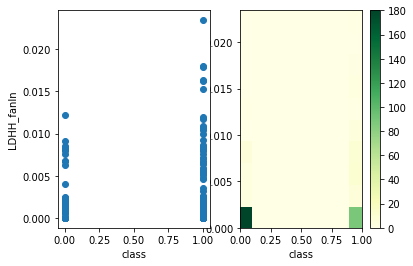

In [ ]:
col_names = AEEEM_EQ.columns
plot_two_columns(AEEEM_EQ, 'class', col_names[3])

### NASA


*   variable name_1, variable range (will be standardized in our analysis)
*   List item


#### Show them examples from the data
correlation between our two favourite metrics?

In [ ]:
import requests
import io

    
url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/CM1-processed.csv" 
download = requests.get(url).content
NASA_CM1 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/KC3-processed.csv" 
download = requests.get(url).content
NASA_KC3 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/MC2-processed.csv" 
download = requests.get(url).content
NASA_MC2 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/MW1-processed.csv" 
download = requests.get(url).content
NASA_MW1 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/PC1-processed.csv" 
download = requests.get(url).content
NASA_PC1 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/PC2-processed.csv" 
download = requests.get(url).content
NASA_PC2 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/PC3-processed.csv" 
download = requests.get(url).content
NASA_PC3 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/anonymous-replication/replication-nasa/master/data/processed/PC4-processed.csv" 
download = requests.get(url).content
NASA_PC4 = pd.read_csv(io.StringIO(download.decode('utf-8')))



In [ ]:
drop_list = []
drop_variables(NASA_CM1, drop_list)
drop_variables(NASA_KC3, drop_list)
drop_variables(NASA_MC2, drop_list)
drop_variables(NASA_MW1, drop_list)
drop_variables(NASA_PC1, drop_list)
drop_variables(NASA_PC2, drop_list)
drop_variables(NASA_PC3, drop_list)
drop_variables(NASA_PC4, drop_list)

In [ ]:
numerical_response(NASA_CM1, 'NASA') 
numerical_response(NASA_KC3, 'NASA') 
numerical_response(NASA_MC2, 'NASA') 
numerical_response(NASA_MW1, 'NASA') 
numerical_response(NASA_PC1, 'NASA') 
numerical_response(NASA_PC2, 'NASA') 
numerical_response(NASA_PC3, 'NASA') 
numerical_response(NASA_PC4, 'NASA') 

In [ ]:

project_dict_NASA = {
  "NASA CM1 ": NASA_CM1,
  "NASA KC3 ": NASA_KC3,
  "NASA MC2 ": NASA_MC2, 
  "NASA MW1 ": NASA_MW1, 
  "NASA PC1 ": NASA_PC1,
  "NASA PC2 ": NASA_PC2,
  "NASA PC3 ": NASA_PC3,
  "NASA PC4 ": NASA_PC4}

### PROMISE


*   variable name_1, variable range (will be standardized in our analysis)
*   List item


#### Show them examples from the data
correlation between our two favourite metrics?

number of bugs - > buggy dataset classify as buggy instead of number of bugs

In [ ]:
url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/camel/camel-1.6.csv" 
download = requests.get(url).content
PROMISE_Camel_v_1_6 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/ivy/ivy-1.2.csv" 
download = requests.get(url).content
PROMISE_IVY_1_2 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/jedit/jedit-4.0.csv" 
download = requests.get(url).content
PROMISE_Jedit_v_4_0 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/log4j/log4j-1.0.csv" 
download = requests.get(url).content
PROMISE_Log4j_v_1_0 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/lucene/lucene-2.4.csv" 
download = requests.get(url).content
PROMISE_Lucene_v_2_4 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/poi/poi-3.0.csv" 
download = requests.get(url).content
PROMISE_POI_v_3_0 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/xalan/xalan-2.6.csv" 
download = requests.get(url).content
PROMISE_Xalan_v_2_6 = pd.read_csv(io.StringIO(download.decode('utf-8')))

url = "https://raw.githubusercontent.com/feiwww/PROMISE-backup/master/bug-data/xerces/xerces-1.3.csv" 
download = requests.get(url).content
PROMISE_Xerces_v_1_3 = pd.read_csv(io.StringIO(download.decode('utf-8')))

drop_list = 'name'
drop_variables(PROMISE_Camel_v_1_6, drop_list)
drop_variables(PROMISE_IVY_1_2, drop_list)
drop_variables(PROMISE_Jedit_v_4_0, drop_list)
drop_variables(PROMISE_Log4j_v_1_0, drop_list)
drop_variables(PROMISE_Lucene_v_2_4, drop_list)
drop_variables(PROMISE_POI_v_3_0, drop_list)
drop_variables(PROMISE_Xalan_v_2_6, drop_list)
drop_variables(PROMISE_Xerces_v_1_3, drop_list)

numerical_response(PROMISE_Camel_v_1_6, 'PROMISE')
numerical_response(PROMISE_IVY_1_2, 'PROMISE')
numerical_response(PROMISE_Jedit_v_4_0, 'PROMISE')
numerical_response(PROMISE_Log4j_v_1_0, 'PROMISE') 
numerical_response(PROMISE_Lucene_v_2_4, 'PROMISE')
numerical_response(PROMISE_POI_v_3_0, 'PROMISE')
numerical_response(PROMISE_Xalan_v_2_6, 'PROMISE') 
numerical_response(PROMISE_Xerces_v_1_3, 'PROMISE') 


In [ ]:
# ADD THE PROJECTS TO A DICTIONARY

project_dict_PROMISE = {
  "PROMISE Camel v1.6 ": PROMISE_Camel_v_1_6,
  "PROMISE IVY v1.2 ": PROMISE_IVY_1_2,
  "PROMISE Jedit v4.0 ": PROMISE_Jedit_v_4_0,
  "PROMISE Log4j v1.0 ": PROMISE_Log4j_v_1_0,
  "PROMISE Lucene v2.4 ": PROMISE_Lucene_v_2_4,
  "PROMISE POI v3.0 ": PROMISE_POI_v_3_0,
  "PROMISE Xalan v2.6 ": PROMISE_Xalan_v_2_6,
  "PROMISE Xerces v1.3 ": PROMISE_Xerces_v_1_3
}


# recreate table 1 

| Dataset | Project | # of Entities | # of Defective | % Defective |
| :- | :- | -: | -: | -: | 
| AEEEM | Eclipse JDT Core | 997 | 206 | 20.7 % |
| AEEEM | Equinox  | 324 | 129 | 39.8 % |
| AEEEM | Apache Lucene  | 691 | 64 | 9.3 % |
| AEEEM | Mylyn  | 1862 | 245 | 13.2 % |
| AEEEM | Eclipse PDE UI  | 778 | 117 | 15.0 % |
| NASA | CM1  | 505 | 48 | 9.5 % |
| NASA | KC3  | 458 | 43 | 9.4 % |
| NASA | MC2  | 161 | 52 | 32.3 % |
| NASA | MW1  | 403 | 31 | 7.7 % |
| NASA | PC1  | 1107 | 76 | 6.9 % |
| NASA | PC2  | 5589 | 23 | 0.4 % |
| NASA | PC3  | 1563 | 160 | 10.2 % |
| NASA | PC4  | 1458 | 178 | 12.2 % |
| Promise | Camel v1.6  | 965 | 188 | 19.5 % |
| Promise | IVY 1.2  | 352 | 40 | 11.4 % |
| Promise | Jedit v4.0  | 306 | 75 | 24.5 % |
| Promise | Log4j v1.0  | 135 | 34 | 25.2 % |
| Promise | Lucene v2.4  | 340 | 203 | 59.7 % |
| Promise | POI v3.0  | 442 | 281 | 63.6 % |
| Promise | Xalan v2.6  | 885 | 411 | 46.4 % |
| Promise | Xerces v1.3  | 453 | 69 | 15.2 % |




# Supervised classifiers


*   Random forest 
*   Naive Bayes 
*   Logistic regression




For the supervised classifiers, we need training data. To predict defects in a target project we fit a model on all the remaining projects and use the average AUC score for that specific supervised classifier. 





## Random forest 

## Short description

Random Forest is a supervised classifier that mitigates some of the difficulties with normal decision trees. Normal decision trees are said to have a higher variance as they are sensitive to training data cf. the algorithms preference for pure nodes. Random Forest mitigates this by creating a “forest” of decision-trees using boot-strapped datasets from the training data. The decided number of new trees are all built on random combinations of the original rows and columns. That is, bootstrapping is applied to decrease the sensitivity to training data and random-feature-selection is used to decrease correlation between our trees and thus decreases the variance of our ML algorithm. To consider test data, the algorithm uses aggregation for majority vote classification to predict, in this case, whether or not the software is defect. 



## Tuning parameters
short discussion

It is common practice to use the square root of the total features per tree.


justify the ones we ended up with 





In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

def random_forest(df_train, df_test):
    '''
    

    Parameters
    ----------
    df_train : TYPE
        DESCRIPTION.
    df_test : TYPE
        DESCRIPTION.

    Returns
    -------
    y_pred : TYPE
        DESCRIPTION.
    y_test : TYPE
        DESCRIPTION.

    '''
    y_train = list(df_train['class'])
    y_test = list(df_test['class'])
    scaled_train_X, scaled_test_X = scale_data(df_train, df_test) 
     
    param_grid = { 
        'n_estimators': [70, 150, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' : ['entropy', 'gini'],
        'class_weight' : ['balanced']}

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)

    rfc = RandomForestClassifier(random_state=7)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring = 'roc_auc')
    CV_rfc.fit(scaled_train_X, y_train)
    rfc_best = RandomForestClassifier(**CV_rfc.best_params_)
    rfc_best.fit(scaled_train_X, y_train)
    y_pred = rfc_best.predict(scaled_test_X)
    print(CV_rfc.best_params_)
 
    return y_pred, y_test

In [ ]:
get_auc_scores(project_dict_AEEEM, random_forest, average_AUC_cross)

#get_auc_scores(project_dict_NASA, random_forest, average_AUC_cross)

#get_auc_scores(project_dict_PROMISE, random_forest, average_AUC_cross)

{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 70}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 70}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}

AUC score for Eclipse JDT Core, AEEEM_JDT   : 0.57
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 70}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}
{'class_weight': {0: 0.5, 1: 2}, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150}

AUC score for Equinox,

In [ ]:
#get_auc_scores(project_dict_AEEEM, random_forest, average_AUC_within)

#get_auc_scores(project_dict_NASA, random_forest, average_AUC_within)

#get_auc_scores(project_dict_PROMISE, random_forest, average_AUC_within)

## Naive Bayes

## Short description

Naive Bayes is a supervised classifier which classifies entities based on probabilities. Probabilities are calculated “naively” by assuming all features are independent from one another. While this may often not reflect reality, it is computationally less demanding than complex models and Naive Bayes tends to perform well. As a result, the authors and many others use is for completeness and it provides a meaningful benchmark to the spectral clustering. Naive Bayes works by computing the conditional probability for each feature. That is, the probability of the feature being true given that the software is defect. Naive Bayes is thus often computed over binary variables, but packages also allow for computing on continuous variables assuming a gaussian distribution or by categorizing the observations into discrete bins.



## Tuning parameters
short discussion

justify the ones we ended up with 

she told us that our data set is not normal distributed (do you also remeber that?) so are we going the right thing by using gaussian NB?




In [ ]:
'''Here I am using the gaussianNB WITHOUT standardizing the data. It provides the highest AUC score'''


from sklearn.naive_bayes import ComplementNB


def naive_bayes(df_train, df_test):
    y_train = list(df_train['class'])
    y_test = list(df_test['class'])
    X_train = df_train.iloc[:,:-1]
    X_test = df_test.iloc[:,:-1]
    # class_prior
    
    prob1 = sum(y_train)/len(y_train)
    prob0 = 1 - prob1
    
    cnb = ComplementNB(alpha = prob1, class_prior = ((prob0, prob1)))
    cnb.fit(X_train, y_train)
    y_pred = cnb.predict(X_test)
    return y_pred, y_test

auc = get_auc_scores(project_dict_AEEEM, naive_bayes, average_AUC_within)

# suggest not scaling 
# ComplementNB used for unbalanced data sets
# remove correlated variables ?



In [ ]:
get_auc_scores(project_dict_AEEEM, naive_bayes, average_AUC_cross)

#get_auc_scores(project_dict_NASA, naive_bayes, average_AUC_cross)

#get_auc_scores(project_dict_PROMISE, naive_bayes, average_AUC_cross)


AUC score for Eclipse JDT Core, AEEEM_JDT   : 0.93

AUC score for Equinox, AEEEM_EQ  : 0.96

AUC score for Apache Lucene , AEEEM_LC  : 0.96

AUC score for Mylyn, AEEEM_ML : 0.86

AUC score for Eclipse PDE UI, AEEEM_PDE  : 0.95

Mean AUC score for all projects: 0.93


In [ ]:
get_auc_scores(project_dict_AEEEM, naive_bayes, average_AUC_within)

#get_auc_scores(project_dict_NASA, naive_bayes, average_AUC_within)

#get_auc_scores(project_dict_PROMISE, naive_bayes, average_AUC_within)


AUC score for Eclipse JDT Core, AEEEM_JDT   : 0.89

AUC score for Equinox, AEEEM_EQ  : 1.0

AUC score for Apache Lucene , AEEEM_LC  : 1.0

AUC score for Mylyn, AEEEM_ML : 1.0

AUC score for Eclipse PDE UI, AEEEM_PDE  : 1.0

Mean AUC score for all projects: 0.98


## Logistic regression
## Short description

Logistic Regression is a supervised classifier that uses probability to predict the label of an entity. Firstly, multiple linear regression is used to find the weight of each predictor variable. When the goal is to classify binary variables, as opposed to continuous variables, it makes little sense to talk about a linear effect of changing the predictor values. Rather, it makes sense to investigate how much the probability of software being defect changes when a predictor’s value changes. Ultimately, logistic regression provides an approach to classify or prioritize among variables based on their probability to be e.g. defect.

To transform this multi-linear relationship, the sigmoid function is often applied:
$$
p = \frac{e^{ x \vec{\beta}}}{1+e^x \vec{\beta}}, \quad x \vec{\beta} = \beta_0 + x_1 \beta_1 + ... + x_p \beta_p, 
$$ 
where $x_i$ is the i-th column.             
The sigmoid function above tells us that the probability of defect software is increasing in x and approaches 1 (that is, 100%) as x goes up. X is the beta-estimator of each predictor-variable. A threshold is then passed to the logistic regression to decide at which probabilities the observation should be classified as true/false. This is a meaningful difference to linear regression which merely fits a line (or plane) through the datapoints to minimize the squared errors but does not help classifying. 


///As with other supervised classifiers, the logistic regression is a serious contender for datasets with much training data. However, as the authors emphasize, software defect prediction is typically not based on large amounts of data. Rather on smaller individual projects with heterogeneous metrics that makes it infeasible and suboptimal to train models to predict the defects. It is nonetheless interesting to compare the performance of the logistic regression to proxy what could be expected to be achieved, ceteris paribus, if data was fully available. Thereby assessing whether spectral clustering underperforms or not. [this is loosely written and we should definitely cut down but I wanted to have too much rather than too little]///


## Tuning parameters
short discussion

justify the ones we ended up with 



In [ ]:
#@title
from sklearn.linear_model import LogisticRegression

def LR(df_train, df_test):
    y_train = list(df_train['class'])
    y_test = list(df_test['class'])
    scaled_train_X, scaled_test_X = scale_data(df_train, df_test)
    # scaled_train_X = df_train.iloc[:,:-1]
    # scaled_test_X = df_test.iloc[:,:-1]

    model = LogisticRegression(random_state=0, max_iter = 500)
    model.fit(scaled_train_X, y_train)


    y_pred = model.predict(scaled_test_X)
    y_test = y_test
    return y_pred, y_test

    # df_result_training = pd.DataFrame([y_test, y_pred])
    # df_result_training = df_result_training.T
    # df_result_training.columns = ["Label_GT", "Label_Pred"]
    # df_result_training.head(10)


In [ ]:
from sklearn.linear_model import LogisticRegression

def LR(df_train, df_test):
    from sklearn.datasets import make_blobs
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    #Model data
    y_train = list(df_train['class'])
    y_test = list(df_test['class'])
    scaled_train_X, scaled_test_X = scale_data(df_train, df_test)
    
    #Applt these if we want to try without scaling the data:
    #scaled_train_X = df_train.iloc[:,:-1]
    #scaled_test_X = df_test.iloc[:,:-1]

    #Model and parameters:
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]

    #Define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
    grid_result = grid_search.fit(scaled_train_X, y_train)
    
    #Summarize Results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

    
    y_pred = grid_result.predict(scaled_test_X)
    y_test = y_test
    return y_pred, y_test


In [ ]:

y_pred, y_test = LR(AEEEM_JDT, AEEEM_EQ)
AUC = roc_auc_score(y_test, y_pred)
print(AUC)

#get_auc_scores(project_dict_AEEEM, LR, average_AUC_cross)

#get_auc_scores(project_dict_NASA, LR, average_AUC_cross)

#get_auc_scores(project_dict_PROMISE, LR, average_AUC_cross)


Best: 0.850997 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.834024 (0.025295) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.833116 (0.025670) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.834055 (0.025298) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.833182 (0.025436) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.833128 (0.025756) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.833355 (0.025490) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.832942 (0.028030) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832891 (0.028026) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.833157 (0.027977) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.848079 (0.032905) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.848100 (0.032940) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.850997 (0.031045) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.844230 (0.031360) wit

In [ ]:
get_auc_scores(project_dict_AEEEM, LR, average_AUC_within)

get_auc_scores(project_dict_NASA, LR, average_AUC_within)

get_auc_scores(project_dict_PROMISE, LR, average_AUC_within)



AUC score for Eclipse JDT Core, AEEEM_JDT   : 0.7

AUC score for Equinox, AEEEM_EQ  : 0.7

AUC score for Apache Lucene , AEEEM_LC  : 0.61

AUC score for Mylyn, AEEEM_ML : 0.58

AUC score for Eclipse PDE UI, AEEEM_PDE  : 0.58

Mean AUC score for all projects: 0.63

AUC score for NASA CM1  : 0.55

AUC score for NASA KC3  : 0.58

AUC score for NASA MC2  : 0.6

AUC score for NASA MW1  : 0.58

AUC score for NASA PC1  : 0.55

AUC score for NASA PC2  : 0.52

AUC score for NASA PC3  : 0.55

AUC score for NASA PC4  : 0.75

Mean AUC score for all projects: 0.58

AUC score for PROMISE Camel v1.6  : 0.55

AUC score for PROMISE IVY v1.2  : 0.58

AUC score for PROMISE Jedit v4.0  : 0.64

AUC score for PROMISE Log4j v1.0  : 0.71

AUC score for PROMISE Lucene v2.4  : 0.68

AUC score for PROMISE POI v3.0  : 0.73

AUC score for PROMISE Xalan v2.6  : 0.72

AUC score for PROMISE Xerces v1.3  : 0.64

Mean AUC score for all projects: 0.66


# Unsupervised classifiers

Does not require training data, therefore avoids the heterogenety problem.
Distance based clustering methods: 
* K-means clustering (KM)

Not distance based methods
* Spectral clustering

## K-means clustering 
k = 2 gives the best performance [20]. One cluster is labeled defective and one is labeled clean. 

## Short description
K-mean is an unsupervised distance-based algorithm that looks for clusters in a dataset. It is initiated by determining “k” number of clusters. In our case, we will use two since we want a “defect” and “not defect” cluster. The algorithm randomly chooses k number of centroids in feature space. Centroids are simply a starting point in our space. The k-mean algorithm then assigns all data-points to the centroid they are located the closest to base on the Euclidian distance. Once all datapoints have been assigned to a cluster, the centroids of these clusters will be updated to the mean of the clusters. The model iterates this process until the centroids no longer changes. 
That is 1) reassigning datapoints to their closest centroid and 2) updating the centroid to be the middle of the data points. Once the centroids no longer move, the model terminates. 

As the number of features increase, any distance based algorithm's similarity measure will converge toward some constant. The so-called curse of dimensionality. This will translates into worse performance. K-means are therefore better suited for less features. On the other hand, k-means typically performs well, for less features that is, and do not have rigid assumptions about the data. It is thus a default ML technique to test when trying to classify variables. 



## Tuning parameters
An issue with k-means is its sensitivity to the initial centroids. It does not guarantee the best solution but rather stops at a local equilibrium. For that reason, we choose to iterate the process many times to ensure that we do get a good prediction.



In [ ]:

from sklearn.cluster import KMeans

def KN(df_train):
    y_train = list(df_train['class'])
    scaled_train_X = scale_data_unsupervised(df_train)

    kmeans = KMeans(n_clusters=2, n_init=200, random_state = 7, tol = 0.0001)
    kmeans.fit(scaled_train_X)
    y_pred = kmeans.predict(scaled_train_X)
    return y_pred, y_train



In [ ]:
get_auc_scores(project_dict_AEEEM, KN, AUC_unsupervised)

#get_auc_scores(project_dict_NASA, KN, AUC_unsupervised)

#get_auc_scores(project_dict_PROMISE, KN, AUC_unsupervised)


AUC score for Eclipse JDT Core, AEEEM_JDT   : 0.67

AUC score for Equinox, AEEEM_EQ  : 0.56

AUC score for Apache Lucene , AEEEM_LC  : 0.42

AUC score for Mylyn, AEEEM_ML : 0.58

AUC score for Eclipse PDE UI, AEEEM_PDE  : 0.62

Mean AUC score for all projects: 0.57


## Spectral clustering
Spectral clustering partitions a data set based on the connectivity between its entities. 

Each node represents a  software entity (file or class)
Each edge represents the connection between software entities, and its weight is measured by the similarity of metric values between its two ends. 

similarity:
$$
w_{i,j} = \textbf{x}_{i} ⋅ \textbf{x}_{j} = \sum_{k=1}^{m} a_{i,k} a_{k,j}
,$$
$x_i$ and $x_j$ denote the metric values of software entities $i$ and $j$, respectively,

$a_{k,j}$ is the value of the $k$-th metric on the $j$-th software entity and m is the total number of metrics. 

## Short description

*   unsupervised / supervised
*   hierarchical method or .... 
*   typically good for, when is it used, why have we  included it



## Tuning parameters
short discussion

justify the ones we ended up with 

## Math / pseudocode

In [ ]:
from sklearn.cluster import SpectralClustering

def adjacency_matrix(df):
    # Normalize software metrices unsing z-score 
    y = np.zeros(np.shape(df)[0])
    #y = list(df["class"])
    n = len(y)
    scaled_X = scale_data_unsupervised(df)
    
    # Construct a weighted adjacency matrix W
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j != i:
                W[i,j] = np.dot(scaled_X.iloc[i, :], scaled_X.iloc[j, :])
    W = W.clip(min=0)
    return W

def spectral_clustering(df, df_test=0):
    y = list(df["class"])
    scaled_X = scale_data_unsupervised(df)
    W = adjacency_matrix(df)
    clustering = SpectralClustering(n_clusters=2, affinity = 'precomputed', random_state = 2, n_jobs = -1)
    clustering.fit(W)   
    y_pred = clustering.labels_
    return y_pred, y

In [ ]:
get_auc_scores(project_dict_AEEEM, spectral_clustering, AUC_unsupervised)

#get_auc_scores(project_dict_NASA, spectral_clustering, AUC_unsupervised)

#get_auc_scores(project_dict_PROMISE, spectral_clustering, AUC_unsupervised)


KeyboardInterrupt: ignored

# Performance




## AUC



## Scott Knot test
To compare the predictive power among all classifiers, we apply the Scott-Knott test with the 95% confidence level to rank all classifiers across projects within the same dataset. We examine the Scott-Knott ranks per dataset. Furthermore, we perform one large Scott-Knott run where we input all the AUC values for all the classifiers across all datasets. 

(this is copied from the rapport and must be rewritten if we are going to use it in our priject)

# Discussion 

# Future suggestions


# APPENDIX 1 - DATA TABLE NAMES
| Metric                            | Description                                                  |
| --------------------------------- | ------------------------------------------------------------ |
| classname                         | Name of the class                                            |
| numberOfVersionsUntil. (NR)       | Number of versions (revisions) before last release           |
| numberOfFixesUntil. (NFIX)        | Number of fixes before last release                          |
| numberOfRefactoringsUntil. (NREF) | Number of refactorings before last release                   |
| numberOfAuthorsUntil. (NAUTH)     | Number of authors before last release                        |
| linesAddedUntil.                  | Sum of all the lines added between all the revisions (before last release) |
| maxLinesAddedUntil.               | Maximum number of lines added in a single revision           |
| avgLinesAddedUntil.               | Average number of lines added in a single revision           |
| linesRemovedUntil.                | Sum of all the lines removed between all the revisions (before last release) |
| maxLinesRemovedUntil.             | Maximum number of lines removed in a single revision         |
| avgLinesRemovedUntil.             | Average number of lines removed in a single revision         |
| codeChurnUntil.                   | How many times the class has been edited between all the revisions before last release |
| maxCodeChurnUntil.                | Maximum number of times the class has been edited in a single revision |
| avgCodeChurnUntil.                | Average number of times the class has been edited in a single revision |
| ageWithRespectTo.                 | Age of the class                                             |
| weightedAgeWithRespectTo.         | Weighted age of the class                                    |
| bugs                              | Number of bugs found after last release                      |
| nonTrivialBugs                    | Number of non trivial bugs found after last release          |
| majorBugs                         | Number of major bugs found after last release                |
| criticalBugs                      | Number of critical bugs found after last release             |
| highPriorityBugs                  | Number of high priority bugs found after last release        |


| Metric                 | Description                                                  |
| ---------------------- | ------------------------------------------------------------ |
| classname              | Name of the class                                            |
| CvsEntropy (HCM)       | History of complexity metric                                 |
| CvsWEntropy (WHCM)     | Weighted history of complexity metric                        |
| CvsLinEntropy (LDHCM)  | Linearly decayed history of complexity metric (the contributions given by every change decay linearly) |
| CvsLogEntropy (LGDHCM) | Logarithmically decayed history of complexity metric (the contributions given by every change decay logarithmically) |
| CvsExpEntropy (EDHCM)  | Exponentially decayed history of complexity metric (the contributions given by every change decay exponentially) |


| Metric                              | Description                                            |
| ----------------------------------- | ------------------------------------------------------ |
| classname                           | Name of the class                                      |
| numberOfBugsFoundUntil.             | Number of bugs found before last release               |
| numberOfNonTrivialBugsFoundUntil.   | Number of non trivial bugs found before last release   |
| numberOfMajorBugsFoundUntil.        | Number of major bugs found before last release         |
| numberOfCriticalBugsFoundUntil.     | Number of critical bugs found before last release      |
| numberOfHighPriorityBugsFoundUntil. | Number of high priority bugs found before last release |
| bugs                                | Number of bugs found after last release                |
| nonTrivialBugs                      | Number of non trivial bugs found after last release    |
| majorBugs                           | Number of major bugs found after last release          |
| criticalBugs                        | Number of critical bugs found after last release       |
| highPriorityBugs                    | Number of high priority bugs found after last release  |

* Contains all the CK (from the Chidamber and Kemerer suite) and OO (object-oriented) metrics.

| Metric                             | Description                                             |
| ---------------------------------- | ------------------------------------------------------- |
| classname                          | Name of the class                                       |
| cbo                                | Coupling between objects (CK)                           |
| dit                                | Depth of inheritance tree (CK)                          |
| fanIn                              | Number of classes that reference the class (OO)         |
| fanOut                             | Number of classes that are referenced by the class (OO) |
| lcom                               | Lack of cohesion in methods (CK)                        |
| noc                                | Number of children (CK)                                 |
| numberOfAttributes (NOA)           | Number of attributes in the class (OO)                  |
| numberOfAttributesInherited (NOAI) | Number of attributes inherited by the class (OO)        |
| numberOfLinesOfCode (LOC)          | Lines of code (OO)                                      |
| numberOfMethods (NOM)              | Number of methods in the class (OO)                     |
| numberOfMethodsInherited (NOMI)    | Number of methods inherited by the class (OO)           |
| numberOfPrivateAttributes (NOPRA)  | Number of private attributes in the class (OO)          |
| numberOfPrivateMethods (NOPRM)     | Number of private methods in the class (OO)             |
| numberOfPublicAttributes (NOPA)    | Number of public attributes in the class (OO)           |
| numberOfPublicMethods (NOPM)       | Number of public methods in the class (OO)              |
| rfc                                | Response for class (CK)                                 |
| wmc                                | Weighted method count (CK)                              |
| bugs                               | Number of bugs found after last release                 |
| nonTrivialBugs                     | Number of non trivial bugs found after last release     |
| majorBugs                          | Number of major bugs found after last release           |
| criticalBugs                       | Number of critical bugs found after last release        |
| highPriorityBugs                   | Number of high priority bugs found after last release   |

* Contains the entropy calculated for every CK and OO metric.

| Metric                      | Description                                           |
| --------------------------- | ----------------------------------------------------- |
| cbo                         | Entropy for cbo                                       |
| dit                         | Entropy for dit                                       |
| fanIn                       | Entropy for fanIn                                     |
| fanOut                      | Entropy for fanOut                                    |
| lcom                        | Entropy for lcom                                      |
| noc                         | Entropy for noc                                       |
| numberOfAttributes          | Entropy for numberOfAttributes                        |
| numberOfAttributesInherited | Entropy for numberOfAttributesInherited               |
| numberOfLinesOfCode         | Entropy for numberOfLinesOfCode                       |
| numberOfMethods             | Entropy for numberOfMethods                           |
| numberOfMethodsInherited    | Entropy for numberOfMethodsInherited                  |
| numberOfPrivateAttributes   | Entropy for numberOfPrivateAttributes                 |
| numberOfPrivateMethods      | Entropy for numberOfPrivateMethods                    |
| numberOfPublicAttributes    | Entropy for numberOfPublicAttributes                  |
| numberOfPublicMethods       | Entropy for numberOfPublicMethods                     |
| rfc                         | Entropy for rfc                                       |
| wmc                         | Entropy for wmc                                       |
| bugs                        | Number of bugs found after last release               |
| nonTrivialBugs              | Number of non trivial bugs found after last release   |
| majorBugs                   | Number of major bugs found after last release         |
| criticalBugs                | Number of critical bugs found after last release      |
| highPriorityBugs            | Number of high priority bugs found after last release |

* Contains the code churn calculated for every CK and OO metric. The code churn measures how frequently the metrics have changed in time. Classes with very high code churn for many metrics will have more bugs.

| Metric                      | Description                                           |
| --------------------------- | ----------------------------------------------------- |
| cbo                         | Code churn cbo                                        |
| dit                         | Code churn dit                                        |
| fanIn                       | Code churn fanIn                                      |
| fanOut                      | Code churn fanOut                                     |
| lcom                        | Code churn lcom                                       |
| noc                         | Code churn noc                                        |
| numberOfAttributes          | Code churn numberOfAttributes                         |
| numberOfAttributesInherited | Code churn numberOfAttributesInherited                |
| numberOfLinesOfCode         | Code churn numberOfLinesOfCode                        |
| numberOfMethods             | Code churn numberOfMethods                            |
| numberOfMethodsInherited    | Code churn numberOfMethodsInherited                   |
| numberOfPrivateAttributes   | Code churn numberOfPrivateAttributes                  |
| numberOfPrivateMethods      | Code churn numberOfPrivateMethods                     |
| numberOfPublicAttributes    | Code churn numberOfPublicAttributes                   |
| numberOfPublicMethods       | Code churn numberOfPublicMethods                      |
| rfc                         | Code churn rfc                                        |
| wmc                         | Code churn wmc                                        |
| bugs                        | Number of bugs found after last release               |
| nonTrivialBugs              | Number of non trivial bugs found after last release   |
| majorBugs                   | Number of major bugs found after last release         |
| criticalBugs                | Number of critical bugs found after last release      |
| highPriorityBugs            | Number of high priority bugs found after last release |

NB: to access the tables containing transformations of these code churn values, it is necessary to add the transformation option (which can be exp, lin, log, weighted).

* Contains data about how each CK metric changes over time, for every class. 

| Time      | Description                                                  |
| --------- | ------------------------------------------------------------ |
| classname | Name of the class                                            |
| Time 1    | First value recorded of the selected metric                  |
| Time 2    | Second value recorded of the selected metric (recorded after two weeks from the first) |
| ...       | ...                                                          |
| Time 50   | Last value recorded of the selected metric (2 years and 1 month after the first value recorded) |

NB: when the value of the metric hasn't changed between one time and the other, its value is set to -1.

* Contains complexity metrics and values for the abstract syntax tree nodes at the file level.

Note: FOUT_sum is the same as fanOut 

| Complexity Metrics | Description                            |
| ------------------ | -------------------------------------- |
| plugin             | Name of the plugin                     |
| filename           | Name of the file                       |
| pre                | Pre release number of defects          |
| post               | Post release number of defects         |
| ACD                | Number of anonymous type declarations  |
| FOUT_avg           | Average number of method calls         |
| FOUT_max           | Maximum number of method calls         |
| FOUT_sum           | Sum of all method calls                |
| MLOC_avg           | Method lines of code                   |
| MLOC_max           | Maximum method lines of code           |
| MLOC_sum           | Sum of all method lines of code        |
| NBD_avg            | Average nested block depth             |
| NBD_max            | Maximum nested block depth             |
| NBD_sum            | Sum of nested block depth              |
| NOF_avg            | Average number of fields               |
| NOF_max            | Maximum number of fields               |
| NOF_sum            | Sum of number of fields                |
| NOI_avg            | Average number of interfaces           |
| NOI_max            | Maximum number of interfaces           |
| NOI_sum            | Sum of number of interfaces            |
| NOM_avg            | Average number of methods              |
| NOM_max            | Maximum number of methods              |
| NOM_sum            | Sum of number of methods               |
| NOT                | Number of classes                      |
| NSF_avg            | Average number of static fields        |
| NSF_max            | Maximum number of static fields        |
| NSF_sum            | Sum of number of static fields         |
| NSM_avg            | Average number of static methods       |
| NSM_max            | Maximum number of static methods       |
| NSM_sum            | Sum of number of static methods        |
| PAR_avg            | Average number of parameters           |
| PAR_max            | Maximum number of parameters           |
| PAR_sum            | Sum of number of parameters            |
| TLOC               | Total lines of code                    |
| VG_avg             | Average McCabe's cyclomatic complexity |
| VG_max             | Maximum McCabe's cyclomatic complexity |
| VG_sum             | Sum of McCabe's cyclomatic complexity  |

* Contains complexity metrics and values for the abstract syntax tree nodes at the package level.

In this type of table the average, maximum and sum of ACD, NOT and TLOC have been computed (not the single values). Also the variable NOCU has been added (number of files for every package).

| Complexity Metrics | Description                                   |
| ------------------ | --------------------------------------------- |
| plugin             | Name of the plugin                            |
| packagename        | Name of the package                           |
| pre                | Pre release number of defects                 |
| post               | Post release number of defects                |
| ACD_avg            | Average number of anonymous type declarations |
| ACD_max            | Maximum number of anonymous type declarations |
| ACD_sum            | Sum of number of anonymous type declarations  |
| FOUT_avg           | Average number of method calls                |
| FOUT_max           | Maximum number of method calls                |
| FOUT_sum           | Sum of all method calls                       |
| MLOC_avg           | Method lines of code                          |
| MLOC_max           | Maximum method lines of code                  |
| MLOC_sum           | Sum of all method lines of code               |
| NBD_avg            | Average nested block depth                    |
| NBD_max            | Maximum nested block depth                    |
| NBD_sum            | Sum of nested block depth                     |
| NOCU               | Number of compilation units (files)           |
| NOF_avg            | Average number of fields                      |
| NOF_max            | Maximum number of fields                      |
| NOF_sum            | Sum of number of fields                       |
| NOI_avg            | Average number of interfaces                  |
| NOI_max            | Maximum number of interfaces                  |
| NOI_sum            | Sum of number of interfaces                   |
| NOM_avg            | Average number of methods                     |
| NOM_max            | Maximum number of methods                     |
| NOM_sum            | Sum of number of methods                      |
| NOT_avg            | Average number of classes                     |
| NOT_max            | Maximum number of classes                     |
| NOT_sum            | Sum of number of classes                      |
| NSF_avg            | Average number of static fields               |
| NSF_max            | Maximum number of static fields               |
| NSF_sum            | Sum of number of static fields                |
| NSM_avg            | Average number of static methods              |
| NSM_max            | Maximum number of static methods              |
| NSM_sum            | Sum of number of static methods               |
| PAR_avg            | Average number of parameters                  |
| PAR_max            | Maximum number of parameters                  |
| PAR_sum            | Sum of number of parameters                   |
| TLOC_avg           | Average number of total lines of code         |
| TLOC_max           | Maximum number of total lines of code         |
| TLOC_sum           | Sum of number of total lines of code          |
| VG_avg             | Average McCabe's cyclomatic complexity        |
| VG_max             | Maximum McCabe's cyclomatic complexity        |
| VG_sum             | Sum of McCabe's cyclomatic complexity         |

* Contains burst metrics at hourly time intervals. 

| Metric                          | Description                                                  |
| ------------------------------- | ------------------------------------------------------------ |
| filename                        | Name of the class                                            |
| TotalPeopleInBurst              | Number of people involved across all bursts                  |
| MaximumCodeBurstLate            | Maximum late code bursts                                     |
| NumberOfChanges                 | Number of builds in which the component has changed          |
| MaxPeopleInBurst                | Across all bursts, maximum number of people involved         |
| TotalBurstSizeLate              | Total size of late bursts                                    |
| NumberCodeBurstsLate            | Number of late code bursts                                   |
| NumberOfChangesLate             | Number of late builds in which the component has changed     |
| NumberOfChangesEarly            | Number of early builds in which the component has changed    |
| MaxChurnInBurst                 | Maximum code churn across all bursts                         |
| MaximumCodeBurstEarly           | Maximum number of early code bursts                          |
| NumberCodeBurstsEarly           | Number of early code bursts                                  |
| TimeFirstBurst                  | Time when the first burst occurred                           |
| TotalChurnInBurst               | Total code churn in all change bursts                        |
| ChurnTotal                      | Total code churn during the lifetime of a component          |
| MaximumCodeBurst                | Maximum number of code bursts                                |
| NumberOfConsecutiveChangesEarly | Number of early consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| NumberConsecutiveChangesLate    | Number of late consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TotalBurstSizeEarly             | Total size of early bursts                                   |
| TotalBurstSize                  | Total size of all bursts                                     |
| TimeMaxBurst                    | Time when the maximum burst occurred                         |
| NumberOfConsecutiveChanges      | Number of consecutive changes (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TimeLastBurst                   | Time when the last burst occurred                            |
| NumberCodeBursts                | Number of code bursts                                        |
| PeopleTotal                     | Number of people who ever committed a change to the component |

At hourly time intervals we don't have a column with the number of bugs, so this data will be suited for unsupervised learning.

Contains burst metrics at daily time intervals, at the class level.

| Metric                          | Description                                                  |
| ------------------------------- | ------------------------------------------------------------ |
| filename                        | Name of the class                                            |
| TotalPeopleInBurst              | Number of people involved across all bursts                  |
| MaximumCodeBurstLate            | Maximum late code bursts                                     |
| NumberOfChanges                 | Number of builds in which the component has changed          |
| MaxPeopleInBurst                | Across all bursts, maximum number of people involved         |
| TotalBurstSizeLate              | Total size of late bursts                                    |
| NumberCodeBurstsLate            | Number of late code bursts                                   |
| NumberOfChangesLate             | Number of late builds in which the component has changed     |
| NumberOfChangesEarly            | Number of early builds in which the component has changed    |
| MaxChurnInBurst                 | Maximum code churn across all bursts                         |
| MaximumCodeBurstEarly           | Maximum number of early code bursts                          |
| NumberCodeBurstsEarly           | Number of early code bursts                                  |
| TimeFirstBurst                  | Time when the first burst occurred                           |
| TotalChurnInBurst               | Total code churn in all change bursts                        |
| ChurnTotal                      | Total code churn during the lifetime of a component          |
| MaximumCodeBurst                | Maximum number of code bursts                                |
| NumberOfConsecutiveChangesEarly | Number of early consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| NumberConsecutiveChangesLate    | Number of late consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TotalBurstSizeEarly             | Total size of early bursts                                   |
| TotalBurstSize                  | Total size of all bursts                                     |
| TimeMaxBurst                    | Time when the maximum burst occurred                         |
| NumberOfConsecutiveChanges      | Number of consecutive changes (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TimeLastBurst                   | Time when the last burst occurred                            |
| NumberCodeBursts                | Number of code bursts                                        |
| PeopleTotal                     | Number of people who ever committed a change to the component |
| bugs                            | Number of bugs                                               |

* Contains burst metrics at daily time intervals, at the package level. Also contains the same package metrics as the type ecl_package_Version from the above datasets.

| Metric                          | Description                                                  |
| ------------------------------- | ------------------------------------------------------------ |
| filename                        | Name of the package                                          |
| TotalPeopleInBurst              | Number of people involved across all bursts                  |
| MaximumCodeBurstLate            | Maximum late code bursts                                     |
| NumberOfChanges                 | Number of builds in which the component has changed          |
| MaxPeopleInBurst                | Across all bursts, maximum number of people involved         |
| TotalBurstSizeLate              | Total size of late bursts                                    |
| NumberCodeBurstsLate            | Number of late code bursts                                   |
| NumberOfChangesLate             | Number of late builds in which the component has changed     |
| NumberOfChangesEarly            | Number of early builds in which the component has changed    |
| MaxChurnInBurst                 | Maximum code churn across all bursts                         |
| MaximumCodeBurstEarly           | Maximum number of early code bursts                          |
| NumberCodeBurstsEarly           | Number of early code bursts                                  |
| TimeFirstBurst                  | Time when the first burst occurred                           |
| TotalChurnInBurst               | Total code churn in all change bursts                        |
| ChurnTotal                      | Total code churn during the lifetime of a component          |
| MaximumCodeBurst                | Maximum number of code bursts                                |
| NumberOfConsecutiveChangesEarly | Number of early consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| NumberConsecutiveChangesLate    | Number of late consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TotalBurstSizeEarly             | Total size of early bursts                                   |
| TotalBurstSize                  | Total size of all bursts                                     |
| TimeMaxBurst                    | Time when the maximum burst occurred                         |
| NumberOfConsecutiveChanges      | Number of consecutive changes (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TimeLastBurst                   | Time when the last burst occurred                            |
| NumberCodeBursts                | Number of code bursts                                        |
| PeopleTotal                     | Number of people who ever committed a change to the component |
| pre                             | Pre release number of defects                                |
| NumberOfDefects                 | Post release number of defects (equal to "post" from above)  |
| ACD_avg                         | Average number of anonymous type declarations                |
| ACD_max                         | Maximum number of anonymous type declarations                |
| ACD_sum                         | Sum of number of anonymous type declarations                 |
| FOUT_avg                        | Average number of method calls                               |
| FOUT_max                        | Maximum number of method calls                               |
| FOUT_sum                        | Sum of all method calls                                      |
| MLOC_avg                        | Method lines of code                                         |
| MLOC_max                        | Maximum method lines of code                                 |
| MLOC_sum                        | Sum of all method lines of code                              |
| NBD_avg                         | Average nested block depth                                   |
| NBD_max                         | Maximum nested block depth                                   |
| NBD_sum                         | Sum of nested block depth                                    |
| NOCU                            | Number of compilation units (files)                          |
| NOF_avg                         | Average number of fields                                     |
| NOF_max                         | Maximum number of fields                                     |
| NOF_sum                         | Sum of number of fields                                      |
| NOI_avg                         | Average number of interfaces                                 |
| NOI_max                         | Maximum number of interfaces                                 |
| NOI_sum                         | Sum of number of interfaces                                  |
| NOM_avg                         | Average number of methods                                    |
| NOM_max                         | Maximum number of methods                                    |
| NOM_sum                         | Sum of number of methods                                     |
| NOT_avg                         | Average number of classes                                    |
| NOT_max                         | Maximum number of classes                                    |
| NOT_sum                         | Sum of number of classes                                     |
| NSF_avg                         | Average number of static fields                              |
| NSF_max                         | Maximum number of static fields                              |
| NSF_sum                         | Sum of number of static fields                               |
| NSM_avg                         | Average number of static methods                             |
| NSM_max                         | Maximum number of static methods                             |
| NSM_sum                         | Sum of number of static methods                              |
| PAR_avg                         | Average number of parameters                                 |
| PAR_max                         | Maximum number of parameters                                 |
| PAR_sum                         | Sum of number of parameters                                  |
| TLOC_avg                        | Average number of total lines of code                        |
| TLOC_max                        | Maximum number of total lines of code                        |
| TLOC_sum                        | Sum of number of total lines of code                         |
| VG_avg                          | Average McCabe's cyclomatic complexity                       |
| VG_max                          | Maximum McCabe's cyclomatic complexity                       |
| VG_sum                          | Sum of McCabe's cyclomatic complexity                        |

Contains burst metrics at weekly time intervals, at the class level. Also contains the same class metrics as the type ecl_file_Version from the above datasets.

| Metric                          | Description                                                  |
| ------------------------------- | ------------------------------------------------------------ |
| filename                        | Name of the class                                            |
| TotalPeopleInBurst              | Number of people involved across all bursts                  |
| MaximumCodeBurstLate            | Maximum late code bursts                                     |
| NumberOfChanges                 | Number of builds in which the component has changed          |
| MaxPeopleInBurst                | Across all bursts, maximum number of people involved         |
| TotalBurstSizeLate              | Total size of late bursts                                    |
| NumberCodeBurstsLate            | Number of late code bursts                                   |
| NumberOfChangesLate             | Number of late builds in which the component has changed     |
| NumberOfChangesEarly            | Number of early builds in which the component has changed    |
| MaxChurnInBurst                 | Maximum code churn across all bursts                         |
| MaximumCodeBurstEarly           | Maximum number of early code bursts                          |
| NumberCodeBurstsEarly           | Number of early code bursts                                  |
| TimeFirstBurst                  | Time when the first burst occurred                           |
| TotalChurnInBurst               | Total code churn in all change bursts                        |
| ChurnTotal                      | Total code churn during the lifetime of a component          |
| MaximumCodeBurst                | Maximum number of code bursts                                |
| NumberOfConsecutiveChangesEarly | Number of early consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| NumberConsecutiveChangesLate    | Number of late consecutive builds (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TotalBurstSizeEarly             | Total size of early bursts                                   |
| TotalBurstSize                  | Total size of all bursts                                     |
| TimeMaxBurst                    | Time when the maximum burst occurred                         |
| NumberOfConsecutiveChanges      | Number of consecutive changes (takes into account all consecutive changes, not just bursts exceeding a certain size) |
| TimeLastBurst                   | Time when the last burst occurred                            |
| NumberCodeBursts                | Number of code bursts                                        |
| PeopleTotal                     | Number of people who ever committed a change to the component |
| pre                             | Pre release number of defects                                |
| NumberOfDefects                 | Post release number of defects (equal to "post" from above)  |
| ACD                             | Number of anonymous type declarations                        |
| FOUT_avg                        | Average number of method calls                               |
| FOUT_max                        | Maximum number of method calls                               |
| FOUT_sum                        | Sum of all method calls                                      |
| MLOC_avg                        | Method lines of code                                         |
| MLOC_max                        | Maximum method lines of code                                 |
| MLOC_sum                        | Sum of all method lines of code                              |
| NBD_avg                         | Average nested block depth                                   |
| NBD_max                         | Maximum nested block depth                                   |
| NBD_sum                         | Sum of nested block depth                                    |
| NOF_avg                         | Average number of fields                                     |
| NOF_max                         | Maximum number of fields                                     |
| NOF_sum                         | Sum of number of fields                                      |
| NOI_avg                         | Average number of interfaces                                 |
| NOI_max                         | Maximum number of interfaces                                 |
| NOI_sum                         | Sum of number of interfaces                                  |
| NOM_avg                         | Average number of methods                                    |
| NOM_max                         | Maximum number of methods                                    |
| NOM_sum                         | Sum of number of methods                                     |
| NOT                             | Number of classes                                            |
| NSF_avg                         | Average number of static fields                              |
| NSF_max                         | Maximum number of static fields                              |
| NSF_sum                         | Sum of number of static fields                               |
| NSM_avg                         | Average number of static methods                             |
| NSM_max                         | Maximum number of static methods                             |
| NSM_sum                         | Sum of number of static methods                              |
| PAR_avg                         | Average number of parameters                                 |
| PAR_max                         | Maximum number of parameters                                 |
| PAR_sum                         | Sum of number of parameters                                  |
| TLOC                            | Total lines of code                                          |
| VG_avg                          | Average McCabe's cyclomatic complexity                       |
| VG_max                          | Maximum McCabe's cyclomatic complexity                       |
| VG_sum                          | Sum of McCabe's cyclomatic complexity                        |


| Metric                           | Description                                                  |
| -------------------------------- | ------------------------------------------------------------ |
| LOC_BLANK                        | Number of blank lines of code                                |
| BRANCH_COUNT                     | Number of logical branches                                   |
| CALL_PAIRS                       | Executable calls between modules                             |
| LOC_CODE_AND_COMMENT             | Lines of code + lines of comment                             |
| LOC_COMMENTS                     | Lines of comment                                             |
| CONDITION_COUNT                  | Number of conditions                                         |
| CYCLOMATIC_COMPLEXITY            | McCabe's cyclomatic complexity (maximum number of linearly independent paths through a program's source code, computed from the control-flow graph). It's the number of conditional branches in the control-flow graph. M = E - N + 2P (E number of edges, N number of nodes, P number of connected components). Also called v(G). |
| CYCLOMATIC_DENSITY               | Cyclomatic complexity divided by the size of the system (in source statements) |
| DECISION_COUNT                   | Number of decisions                                          |
| DECISION_DENSITY                 | Number of decisions divided by the size of the system        |
| DESIGN_COMPLEXITY                | Number of paths which call something                         |
| DESIGN_DENSITY                   | Design complexity divided by cyclomatic complexity (total paths) |
| EDGE_COUNT                       | Number of edges of the control-flow graph                    |
| ESSENTIAL_COMPLEXITY             | ESSCOM = (NONREDUC+1) + (ENTRYPT-1) + (TERMPT-1) Essential complexity is the sum of nonreducible nodes plus one, plus one for each entry point after the first, plus one for each termination point after the first. It's basically the complexity of the reduced flowgraph (from which the structured constructs have been removed). Called ev(G) |
| ESSENTIAL_DENSITY                | (ESSCOM-1) / (v(G)-1)                                        |
| LOC_EXECUTABLE                   | Lines of executable code                                     |
| PARAMETER_COUNT                  | Number of parameters                                         |
| GLOBAL_DATA_COMPLEXITY           | Complexity of the global data reduced flowgraph (count of paths through global data) |
| GLOBAL_DATA_DENSITY              | GLOBAL_DATA_COMPLEXITY divided by v(G).                      |
| HALSTEAD_CONTENT                 | Equal to L * V (L level, V volume). It represents the complexity regardless of the language used |
| HALSTEAD_DIFFICULTY              | Error proneness of the program, computed as D=(UOP/2)*(OD/UOD) |
| HALSTEAD_EFFORT                  | E = D * V (D difficulty, V volume). It represents the mental effort required to develop or maintain a class |
| HALSTEAD_ERROR_EST               | Estimated Halstead error                                     |
| HALSTEAD_LENGTH                  | Total of all the lengths in the classes                      |
| HALSTEAD_LEVEL                   | L = 1 / D                                                    |
| HALSTEAD_PROG_TIME               | Time (in seconds) to implement a program: T = E / 18 (E Halstead effort). The number 18 comes from empirical experiments |
| HALSTEAD_VOLUME                  | Total of all the volumes in the methods (the volume V is the information content of a program, measured in mathematical bits: V=length(program)*log2(UOD+UOP)). The length(program) = OP+OD. |
| MAINTENANCE_SEVERITY             | ev(G) / v(G) = Essential complexity divided by Cyclomatic complexity |
| MODIFIED_CONDITION_COUNT         | Count for MC/DC (Modified Condition/Decision Coverage)       |
| MULTIPLE_CONDITION_COUNT         | Count for MCC (Multiple Condition Coverage)                  |
| NODE_COUNT                       | Number of nodes in the control-flow graph                    |
| NORMALIZED_CYCLOMATIC_COMPLEXITY | Normalized McCabe's cyclomatic complexity                    |
| NUM_OPERANDS                     | Number of operands (OD)                                      |
| NUM_OPERATORS                    | Number of operators (OP)                                     |
| NUM_UNIQUE_OPERANDS              | Number of unique operands (UOD)                              |
| NUM_UNIQUE_OPERATORS             | Number of unique operators (UOP)                             |
| NUMBER_OF_LINES                  | Number of lines                                              |
| PATHOLOGICAL_COMPLEXITY          | Measures the degree to which a module contains extremely unstructured constructs. Also called pv(G) |
| PERCENT_COMMENTS                 | Percentage of comments in the total lines of code            |
| LOC_TOTAL                        | Total lines of code                                          |
| Defective                        | Y if the class is defective, N if not                        |


| Metric                           | Description                                                  |
| -------------------------------- | ------------------------------------------------------------ |
| LOC_BLANK                        | Number of blank lines of code                                |
| BRANCH_COUNT                     | Number of logical branches                                   |
| CALL_PAIRS                       | Executable calls between modules                             |
| LOC_CODE_AND_COMMENT             | Lines of code + lines of comment                             |
| LOC_COMMENTS                     | Lines of comment                                             |
| CONDITION_COUNT                  | Number of conditions                                         |
| CYCLOMATIC_COMPLEXITY            | McCabe's cyclomatic complexity (maximum number of linearly independent paths through a program's source code, computed from the control-flow graph). It's the number of conditional branches in the control-flow graph. M = E - N + 2P (E number of edges, N number of nodes, P number of connected components). Also called v(G). |
| CYCLOMATIC_DENSITY               | Cyclomatic complexity divided by the size of the system (in source statements) |
| DECISION_COUNT                   | Number of decisions                                          |
| DECISION_DENSITY                 | Number of decisions divided by the size of the system        |
| DESIGN_COMPLEXITY                | Number of paths which call something                         |
| DESIGN_DENSITY                   | Design complexity divided by cyclomatic complexity (total paths) |
| EDGE_COUNT                       | Number of edges of the control-flow graph                    |
| ESSENTIAL_COMPLEXITY             | ESSCOM = (NONREDUC+1) + (ENTRYPT-1) + (TERMPT-1) Essential complexity is the sum of nonreducible nodes plus one, plus one for each entry point after the first, plus one for each termination point after the first. It's basically the complexity of the reduced flowgraph (from which the structured constructs have been removed). Called ev(G) |
| ESSENTIAL_DENSITY                | (ESSCOM-1) / (v(G)-1)                                        |
| LOC_EXECUTABLE                   | Lines of executable code                                     |
| PARAMETER_COUNT                  | Number of parameters                                         |
| HALSTEAD_CONTENT                 | Equal to L * V (L level, V volume). It represents the complexity regardless of the language used |
| HALSTEAD_DIFFICULTY              | Error proneness of the program, computed as D=(UOP/2)*(OD/UOD) |
| HALSTEAD_EFFORT                  | E = D * V (D difficulty, V volume). It represents the mental effort required to develop or maintain a class |
| HALSTEAD_ERROR_EST               | Estimated Halstead error                                     |
| HALSTEAD_LENGTH                  | Total of all the lengths in the classes                      |
| HALSTEAD_LEVEL                   | L = 1 / D                                                    |
| HALSTEAD_PROG_TIME               | Time (in seconds) to implement a program: T = E / 18 (E Halstead effort). The number 18 comes from empirical experiments |
| HALSTEAD_VOLUME                  | Total of all the volumes in the methods (the volume V is the information content of a program, measured in mathematical bits: V=length(program)*log2(UOD+UOP)). The length(program) = OP+OD. |
| MAINTENANCE_SEVERITY             | ev(G) / v(G) = Essential complexity divided by Cyclomatic complexity |
| MODIFIED_CONDITION_COUNT         | Count for MC/DC (Modified Condition/Decision Coverage)       |
| MULTIPLE_CONDITION_COUNT         | Count for MCC (Multiple Condition Coverage)                  |
| NODE_COUNT                       | Number of nodes in the control-flow graph                    |
| NORMALIZED_CYCLOMATIC_COMPLEXITY | Normalized McCabe's cyclomatic complexity                    |
| NUM_OPERANDS                     | Number of operands (OD)                                      |
| NUM_OPERATORS                    | Number of operators (OP)                                     |
| NUM_UNIQUE_OPERANDS              | Number of unique operands (UOD)                              |
| NUM_UNIQUE_OPERATORS             | Number of unique operators (UOP)                             |
| NUMBER_OF_LINES                  | Number of lines                                              |
| PERCENT_COMMENTS                 | Percentage of comments in the total lines of code            |
| LOC_TOTAL                        | Total lines of code                                          |
| Defective                        | Y if the class is defective, N if not                        |


| Metric    | Description                    |
| --------- | ------------------------------ |
| ID        | Class ID                       |
| Name      | Class name                     |
| LongName  | Extended class name            |
| Parent    | Parent ID                      |
| Component | Component ID                   |
| Path      | Directory path                 |
| Line      | Starting line                  |
| Column    | Starting column                |
| EndLine   | Ending line                    |
| EndColumn | Ending column                  |
| CC        | Cyclomatic complexity          |
| CCL       | Not available                               |
| CCO       | Not available                               |
| CI        | Not available                               |
| CLC       | Not available                               |
| CLLC      | Not available                               |
| LDC       | Not available                               |
| LLDC      | Not available                               |
| LCOM5     | Lack of cohesion methods (CK)  |
| NL        | Not available                               |
| NLE       | Not available                               |
| WMC       | Weighted method count (CK)     |
| CBO       | Coupling between objects (CK)  |
| CBOI      | Not available                               |
| NII       | Not available                               |
| NOI       | Number of interfaces           |
| RFC       | Response for a class (CK)      |
| AD        | Anonymous declaration          |
| CD        | Class declarations             |
| CLOC      | Comment lines of code          |
| DLOC      | Not available                               |
| PDA       | Not available                               |
| PUA       | Not available                               |
| TCD       | Not available                               |
| TCLOC     | Total comment lines of code    |
| DIT       | Depth of inheritance tree (CK) |
| NOA       | Number of attributes           |
| NOC       | Number of children (CK)        |
| NOD       | Number of operands                              |
| NOP       | Number of operators                               |
| LLOC      | Logical lines of code                               |
| LOC       | Lines of code                  |
| NA.       | Not available                               |
| NG        | Not available                               |
| NLA       | Not available                               |
| NLG       | Not available                               |
| NLM       | Not available                               |
| NLPA      | Not available                               |
| NLPM      | Not available                               |
| NLS       | Not available                               |
| NM        | Number of methods                               |
| NOS       | Not available                               |
| NPA       | Number of public attributes                               |
| NPM       | Number of public methods                              |
| NS        | Not available                               |
| TLLOC     | Total logical lines of code                               |
| TLOC      | Total lines of code            |
| TNA       | Not available                               |
| TNG       | Not available                               |
| TNLA      | Not available                               |
| TNLG      | Not available                               |
| TNLM      | Not available                               |
| TNLPA     | Not available                               |
| TNLPM     | Not available                               |
| TNLS      | Not available                               |
| TNM       | Not available                               |
| TNOS      | Not available                               |
| TNPA      | Not available                               |
| TNPM      | Not available                               |
| TNS       | Not available                               |

| Warnings and rule violations      | Description                                           |
| --------------------------------- | ----------------------------------------------------- |
| WarningBlocker                    | Number of blocker warnings                            |
| WarningCritical                   | Number of critical warnings                           |
| WarningInfo                       | Number of warning informations                        |
| WarningMajor                      | Number of major warnings                              |
| WarningMinor                      | Number of minor warnings                              |
| Android.Rules                     | Number of android rule violations                     |
| Basic.Rules                       | Number of basic rule violations                       |
| Brace.Rules                       | Number of brace rule violations                       |
| Clone.Implementation.Rules        | Number of clone implementation rule violations        |
| Clone.Metric.Rules                | Number of clone metric rule violations                |
| Code.Size.Rules                   | Number of code size rule violations                   |
| Cohesion.Metric.Rules             | Number of cohesion metric rule violations             |
| Comment.Rules                     | Number of comment rule violations                     |
| Complexity.Metric.Rules           | Number of complexity metric rule violations           |
| Controversial.Rules               | Number of controversial rule violations               |
| Coupling.Metric.Rules             | Number of coupling metric rule violations             |
| Coupling.Rules                    | Number of coupling rule violations                    |
| Design.Rules                      | Number of design rule violations                      |
| Dcoumentation.Metric.Rules        | Number of documentation metric rule violations        |
| Empty.Code.Rules                  | Number of empty code rule violations                  |
| Finalizer.Rules                   | Number of finalizer rule violations                   |
| Import.Statement.Rules            | Number of import statement rule violations            |
| Inheritance.Metric.Rules          | Number of inheritance metric rule violations          |
| J2EE.Rules                        | Number of J2EE rule violations                        |
| JUnit.Rules                       | Number of JUnit rule violations                       |
| Jakarta.Commons.Logging.Rules     | Number of Jakarta commons logging rule violations     |
| Java.Logging.Rules                | Number of Java logging rule violations                |
| JavaBean.Rules                    | Number of JavaBean rule violations                    |
| MigratingToJUnit4.Rules           | Number of migratingToJUnit4 rule violations           |
| Migration.Rules                   | Number of migration rule violations                   |
| Migration13.Rules                 | Number of migration13 rule violations                 |
| Migration14.Rules                 | Number of migration14 rule violations                 |
| Migration15.Rules                 | Number of migration15 rule violations                 |
| Naming.Rules                      | Number of naming rule violations                      |
| Optimization.Rules                | Number of optimization rule violations                |
| Security.Code.Guideline.Rules     | Number of security code guideline rule violations     |
| Size.Metric.Rules                 | Number of size metric rule violations                 |
| Strict.Exception.Rules            | Number of strict exception rule violations            |
| String.and.StringBuffer.Rules     | Number of string and string buffer rule violations    |
| Type.Resolution.Rules             | Number of type resolution rule violations             |
| Unnecessary.and.Unused.Code.Rules | Number of unnecessary and unused code rule violations |
| Vulnerability.Rules               | Number of vulnerability rule violations               |
| Number.of.bugs                    | Number of bugs found                                  |


| Metric                           | Description                                                  |
| -------------------------------- | ------------------------------------------------------------ |
| ID                               | Class ID                                                     |
| Name                             | Class name                                                   |
| LongName                         | Extended class name                                          |
| Parent                           | Parent ID                                                    |
| McCC                             | McCabe's Cyclomatic Complexity                               |
| CLOC                             | Comment lines of code                                        |
| LLOC                             | Logical lines of code                                                             |
| Number.of.commiters              | Number of people who commited a change                       |
| Number.of.developer.commits      | Number of total commits made by all developers for that file |
| Number.of.previous.modifications | Number of previous modifications of the file                 |
| Number.of.previous.fixes         | Number of previous fixes                                     |
| Number.of.bugs                   | Number of bugs found                                         |


| Metric           | Description                            |
| ---------------- | -------------------------------------- |
| QualifiedName    | Complete name of the class             |
| Name             | Name of the class                      |
| Complexity       | Page 19 codemr-intelllij-userguide.pdf |
| Coupling         | Page 19 codemr-intelllij-userguide.pdf |
| Size             | Page 19 codemr-intelllij-userguide.pdf |
| Lack.of.Cohesion | Page 19 codemr-intelllij-userguide.pdf |
| CBO              | Coupling between objects (CK)          |
| RFC              | Response for a class (CK)              |
| SRFC             | Simple response for a class            |
| DIT              | Depth of inheritance tree (CK)         |
| NOC              | Number of children (CK)                |
| WMC              | Weighted method count (CK)             |
| LOC              | Class lines of code                    |
| CMLOC            | Class-methods lines of code            |
| NOF              | Number of fields                       |
| NOSF             | Number of static fields                |
| NOM              | Number of methods                      |
| NOSM             | Number of static methods               |
| NORM             | Number of overridden methods           |
| LCOM             | Lack of cohesion methods (CK)          |
| LCAM             | Lack of cohesion among methods         |
| LTCC             | Lack of tight class cohesion           |
| ATFD             | Access to foreign data                 |


| Metric           | Description                            |
| ---------------- | -------------------------------------- |
| QualifiedName    | Complete name of the class             |
| Name             | Name of the class                      |
| Complexity       | Page 19 codemr-intelllij-userguide.pdf |
| Coupling         | Page 19 codemr-intelllij-userguide.pdf |
| Size             | Page 19 codemr-intelllij-userguide.pdf |
| Lack.of.Cohesion | Page 19 codemr-intelllij-userguide.pdf |
| Coverage         | Coverage (for packages)                |
| #CI              | Number of classes and interfaces       |
| #C               | Number of classes                      |
| #I               | Number of interfaces                   |
| LOC.1            | Package lines of code                  |
| AC               | Afferent coupling (equal to fanIn)     |
| EC               | Efferent coupling (equal to fanOut)    |
| Abs              | Abstractions                           |
| Ins              | Instability                            |
| ND               | Normalized distance                    |


| Metric           | Description                            |
| ---------------- | -------------------------------------- |
| QualifiedName    | Complete name of the class             |
| Name             | Name of the class                      |
| Complexity       | Page 19 codemr-intelllij-userguide.pdf |
| Coupling         | Page 19 codemr-intelllij-userguide.pdf |
| Size             | Page 19 codemr-intelllij-userguide.pdf |
| Lack.of.Cohesion | Page 19 codemr-intelllij-userguide.pdf |
| WMC.1            | Weighted method count (for methods)    |
| Coverage.1       | Coverage (for methods)                 |
| MCC              | McCabe's Cyclomatic Complexity         |
| NBD              | Nested Block Depth                     |
| LOC.2            | Method lines of code                   |
| #Pa              | Number of parameters                   |
| #MC              | Number of methods called               |
| #AF              | Number of accessed fields              |


